# Machine Learning Project, Task 1: Feature Engineering

In [3]:
# Imports
import pandas as pd
import math
import numpy as np
from sklearn.model_selection import cross_val_score
from xgboost.sklearn import XGBRegressor
import xgboost as xgb

## Utility Methods

In [4]:
def haversine_distance(origin, destination):
    """
    # Formula to calculate the spherical distance between 2 coordinates, with each specified as a (lat, lng) tuple

    :param origin: (lat, lng)
    :type origin: tuple
    :param destination: (lat, lng)
    :type destination: tuple
    :return: haversine distance
    :rtype: float
    """
    lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 6371  # km

    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = math.sin(dlat / 2) * math.sin(dlat / 2) + math.cos(math.radians(lat1)) * math.cos(
        math.radians(lat2)) * math.sin(dlon / 2) * math.sin(dlon / 2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    d = radius * c

    return d

def get_dist(target_coor, trip):
    dropoff_coor = (trip['dropoff_latitude'], trip['dropoff_longitude'])
    distance = round(haversine_distance(target_coor, dropoff_coor), 2)
    return distance

def cal_dist(df):
    jfk_coor = (40.6413, -73.7781)
    lga_coor = (40.7769, -73.8740)
    ewr_coor = (40.6895, -74.1745)
    tsq_coor = (40.7580, -73.9855)
    cpk_coor = (40.7812, -73.9665)
    lib_coor = (40.6892, -74.0445)
    gct_coor = (40.7527, -73.9772)
    met_coor = (40.7794, -73.9632)
    wtc_coor = (40.7126, -74.0099)
    df['jfk'] = df.apply(lambda x: get_dist(jfk_coor, x), axis = 1)
    df['lga'] = df.apply(lambda x: get_dist(lga_coor, x), axis = 1)
    df['ewr'] = df.apply(lambda x: get_dist(ewr_coor, x), axis = 1)
    df['tsq'] = df.apply(lambda x: get_dist(tsq_coor, x), axis = 1)
    df['cpk'] = df.apply(lambda x: get_dist(cpk_coor, x), axis = 1)
    df['lib'] = df.apply(lambda x: get_dist(lib_coor, x), axis = 1)
    df['gct'] = df.apply(lambda x: get_dist(gct_coor, x), axis = 1)
    df['met'] = df.apply(lambda x: get_dist(met_coor, x), axis = 1)
    df['wtc'] = df.apply(lambda x: get_dist(wtc_coor, x), axis = 1)
    return df


## Feature Engineering
> TODO: You need to implement the two functions below to take in raw data, perform data preprocessing and create new features using your knowledge of the problem domain. The main difference between processing test and training data is that **you cannot filter out records from the test set** (i.e., you have to return a prediction even if the input data may be an outlier).

> Feel free to add additional cells to explore the data. You will also find it very helpful to visualize the distribution of the dataset to get a sense of the trends or patterns. **However, you will want to exclude these cells when we export the notebook as an executable.** The submitter will exclude any cells tagged with `excluded_from_script`, so make sure you tag any cells containing exploration code appropriately. You can display the tags for each cell as such: `View > Cell Toolbar > Tags`.

In [5]:
def process_train_data(df):
    """
    TODO: Implement this method.
    
    You may drop rows if needed.

    :param raw_df: the DataFrame of the raw training data
    :return:  a DataFrame with the predictors created
    """
    
    df.drop(df[df['pickup_longitude'] == 0].index, axis=0, inplace = True)
    df.drop(df[df['pickup_latitude'] == 0].index, axis=0, inplace = True)
    df.drop(df[df['dropoff_longitude'] == 0].index, axis=0, inplace = True)
    df.drop(df[df['dropoff_latitude'] == 0].index, axis=0, inplace = True)
    df.drop(df[df['passenger_count'] > 5].index, axis=0, inplace = True)
    df.drop(df[df['passenger_count'] == 0].index, axis=0, inplace = True)

    df['year'] = pd.DatetimeIndex(df['pickup_datetime']).year
    df['month'] = pd.DatetimeIndex(df['pickup_datetime']).month
    df['hour'] = pd.DatetimeIndex(df['pickup_datetime']).hour
    df['weekday'] = pd.DatetimeIndex(df['pickup_datetime']).weekday
    df.dropna(inplace=True)

    df.drop(df.index[(df.pickup_longitude < -75) | 
               (df.pickup_longitude > -72) | 
               (df.pickup_latitude < 40) | 
               (df.pickup_latitude > 42)],inplace=True)
    df.drop(df[df['fare_amount'] < 2.5].index, axis=0, inplace = True)
    df.drop(df[df['fare_amount'] > df['fare_amount'].quantile(.999)].index, axis=0, inplace = True)
    df = cal_dist(df)
    return df


def process_test_data(df):
    """
    TODO: Implement this method.
    
    You should NOT drop any rows.

    :param raw_df: the DataFrame of the raw test data
    :return: a DataFrame with the predictors created
    """
    df['year'] = pd.DatetimeIndex(df['pickup_datetime']).year
    df['month'] = pd.DatetimeIndex(df['pickup_datetime']).month
    df['hour'] = pd.DatetimeIndex(df['pickup_datetime']).hour
    df['weekday'] = pd.DatetimeIndex(df['pickup_datetime']).weekday
    df = cal_dist(df)
    return df

## Model Checking with XGBoost and k-fold Cross Validation
> As you iterate on your features, you want to quickly validate the model and evaluate if these new features help to improve your model's predictions. This process is known as model checking. You will use XGBoost to train the model, and use Root Mean Squared Error (RMSE) to quantify the performance. Cross validation is used to evaluate how the performance of the model will generalize to an unseen dataset.

In [6]:
# Load data
raw_train = pd.read_csv('data/cc_nyc_fare_train_small.csv', parse_dates=['pickup_datetime'])
print('Shape of the raw data: {}'.format(raw_train.shape))

Shape of the raw data: (110222, 8)


In [7]:
# Transform features using the function you have defined
df_train = process_train_data(raw_train)

# Remove fields that we do not want to train with
X = df_train.drop(['key', 'fare_amount', 'pickup_datetime'], axis=1, errors='ignore')

# Extract the value you want to predict
Y = df_train['fare_amount']
print('Shape of the feature matrix: {}'.format(X.shape))

Shape of the feature matrix: (105289, 18)


In [8]:
# Evaluate features with K-fold cross validation
# The higher K is, the longer it takes to run, and the higher your confidence in the score
K = 5
model = XGBRegressor(objective ='reg:squarederror')
scores = cross_val_score(model, X, Y, cv=K, scoring='neg_mean_squared_error', verbose=False)
avg_rmse = math.sqrt(abs(np.mean(scores)))

print('Average RMSE with {}-fold Cross Validation: {:.3f}'.format(K, avg_rmse))

/home/clouduser/virtualenv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=np.int)
/home/clouduser/virtualenv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Dep

Average RMSE with 5-fold Cross Validation: 3.591


## Evaluating Feature Importance
> After you train the model, XGBoost has a handy utility that allows you to compare the relative importance of each feature. You should use this to assess which features you created are meaningful. 

/home/clouduser/virtualenv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

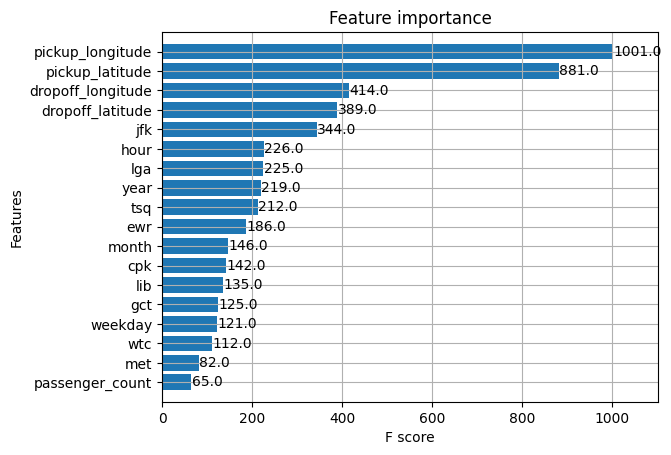

In [9]:
# Train the model again with the entire training set
model = XGBRegressor(objective ='reg:squarederror')
model.fit(X, Y)
xgb.plot_importance(model, height=0.8)

## Evaluating against Hidden Test Set
> Once you are satisfied with the performance of the features you have selected, you can use the trained model to make predictions on the hidden test set. **Do not change the default configuration of the model.** In task 1, you want to focus on feature selection, without worrying about tuning the model.

In [10]:
# Build final model with the entire training set
final_model = XGBRegressor(objective ='reg:squarederror')
final_model.fit(X, Y)

# Read and transform test set
raw_test = pd.read_csv('data/cc_nyc_fare_test.csv', parse_dates=['pickup_datetime'])
df_test = process_test_data(raw_test)
X_test = df_test.drop(['key', 'pickup_datetime'], axis=1, errors='ignore')

# Make predictions for test set and output a csv file
# DO NOT change the column names
df_test['predicted_fare_amount'] = final_model.predict(X_test)
df_test[['key', 'predicted_fare_amount']].to_csv('predictions.csv', index=False)

/home/clouduser/virtualenv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/clouduser/virtualenv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
